In [1]:
import pandas as pd
import numpy as np
try:
    import cPickle as pickle
except ImportError:
    import _pickle as pickle
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import math

In [2]:
def drop_nan(df):
    list_of_nan = []
    for i, row in df.iterrows():
        if pd.isnull(row["bloc"]):
            #print(i)
            list_of_nan.append(i)
            #print(list_of_nan)
    df = df.drop(list_of_nan)
    return df

In [3]:
df_orig = pd.read_csv('../Matlab/MIMIC_mimiciii.csv')
df_orig = drop_nan(df_orig)
for i, row in df_orig.iterrows():
    if pd.isnull(row["mortality_90d"]):
        df_orig.at[i, "mortality_90d"] = 0

In [4]:
#df_orig.head(40)
#type(df_orig["mortality_90d"][15])

In [5]:
df_orig["mortality_90d"].nunique()

2

In [6]:
df_train = pd.read_csv('../Fresh_start/rl_train_set_scaled_rewarded_abchange.csv')
df_train = drop_nan(df_train)

In [7]:
df_preg = pd.read_csv('../Fresh_start/rl_pregnant_set_scaled_rewarded_abchange.csv')
df_preg = drop_nan(df_preg)

In [8]:
df_cont = pd.read_csv('../Fresh_start/rl_control_1_set_scaled_rewarded_abchange.csv')
df_cont = drop_nan(df_cont)

In [9]:
df_cont_sec = pd.read_csv('../Fresh_start/rl_control_2_set_scaled_rewarded_abchange.csv')
df_cont_sec = drop_nan(df_cont_sec)

In [10]:
df_old = pd.read_csv('../Fresh_start/rl_old_set_scaled_rewarded_abchange.csv')
df_old = drop_nan(df_old)

In [11]:
df_test = pd.read_csv('../Fresh_start/rl_test_set_scaled_rewarded_abchange.csv')
df_test = drop_nan(df_test)

In [12]:
df_train_orig = df_orig[df_orig['icustayid'].isin(df_train['icustayid'].unique())]

In [13]:
df_preg_orig = df_orig[df_orig['icustayid'].isin(df_preg['icustayid'].unique())]

In [14]:
df_cont_orig = df_orig[df_orig['icustayid'].isin(df_cont['icustayid'].unique())]

In [15]:
df_cont_sec_orig = df_orig[df_orig['icustayid'].isin(df_cont_sec['icustayid'].unique())]

In [16]:
df_old_orig = df_orig[df_orig['icustayid'].isin(df_old['icustayid'].unique())]

In [17]:
df_test_orig = df_orig[df_orig['icustayid'].isin(df_test['icustayid'].unique())]

In [18]:
len(df_preg) == len(df_preg_orig)

True

In [19]:
False in np.array(df_preg['icustayid']) == np.array(df_preg_orig['icustayid'])

False

In [20]:
interventions = df_train_orig[["max_dose_vaso", "input_4hourly"]]
interventions.head()

,max_dose_vaso,input_4hourly
0,0.0,50.0
1,0.0,50.0
2,0.0,50.0
3,0.0,50.0
4,0.0,50.0


In [21]:
adjusted_vaso = interventions["max_dose_vaso"][interventions["max_dose_vaso"] >0]
adjusted_iv = interventions["input_4hourly"][interventions["input_4hourly"]>0]

In [22]:
vaso_vals = [0]
vaso_vals.extend(adjusted_vaso.quantile([0.125,0.375,0.625,0.875]))
iv_vals = [0]
iv_vals.extend(adjusted_iv.quantile([0.125,0.375,0.625,0.875]))

In [23]:
def sliding_mean(data_array, window=1):
    new_list = []
    for i in range(len(data_array)):
        indices = range(max(i - window + 1, 0),
                        min(i + window + 1, len(data_array)))
        avg = 0
        for j in indices:
            avg += data_array[j]
        avg /= float(len(indices))
        new_list.append(avg)     
    return np.array(new_list)

In [24]:
phys_actions_preg = pickle.load(open( "D:/MIMICIII/Created Data/sarsa_phys/phys_actions_preg.p", "rb" ))

In [25]:
phys_actions_cont = pickle.load(open( "D:/MIMICIII/Created Data/sarsa_phys/phys_actions_cont.p", "rb" ))

In [26]:
phys_actions_cont_sec = pickle.load(open( "D:/MIMICIII/Created Data/sarsa_phys/phys_actions_cont_sec.p", "rb" ))

In [27]:
phys_actions_old = pickle.load(open( "D:/MIMICIII/Created Data/sarsa_phys/phys_actions_old.p", "rb" ))

In [28]:
phys_actions_test = pickle.load(open( "D:/MIMICIII/Created Data/sarsa_phys_2/phys_actions_test.p", "rb" ))

In [29]:
phys_actions_train = pickle.load(open( "D:/MIMICIII/Created Data/sarsa_phys_2/phys_actions_train.p", "rb" ))

In [30]:
deeprl2_actions_preg = pickle.load(open( "C:/Users/sianc/Documents/PhD/First Year/vasochange4_dqn_normal/dqn_normal_actions_preg.p", "rb" ))

In [31]:
deeprl2_actions_cont = pickle.load(open( "C:/Users/sianc/Documents/PhD/First Year/vasochange4_dqn_normal/dqn_normal_actions_cont.p", "rb" ))

In [32]:
deeprl2_actions_cont_sec = pickle.load(open( "C:/Users/sianc/Documents/PhD/First Year/vasochange4_dqn_normal/dqn_normal_actions_cont_sec.p", "rb" ))

In [33]:
deeprl2_actions_old = pickle.load(open( "C:/Users/sianc/Documents/PhD/First Year/vasochange4_dqn_normal/dqn_normal_actions_old.p", "rb" )) #D:/MIMICIII/Created Data/vasochange4_dqn_normal/

In [34]:
deeprl2_actions_test = pickle.load(open( "C:/Users/sianc/Documents/PhD/First Year/vasochange4_dqn_normal/dqn_normal_actions_test.p", "rb" ))

In [35]:
deeprl2_actions_train = pickle.load(open( "C:/Users/sianc/Documents/PhD/First Year/vasochange4_dqn_normal/dqn_normal_actions_train.p", "rb" ))

In [36]:
def create_df_counter(actions_list):
    numb = len(actions_list)
    possible_actions = [i for i in range(0,25)]
    chosen_actions = []
    for i in range(0,25):
        chosen_actions.append(actions_list.count(i)/numb)
    df = pd.DataFrame(columns = ["actions","chosen"])
    df["actions"] = possible_actions
    df["chosen"] = chosen_actions
    return df

In [37]:
deeprl2_df_preg = create_df_counter(deeprl2_actions_preg)
deeprl2_df_cont = create_df_counter(deeprl2_actions_cont)
deeprl2_df_cont_sec = create_df_counter(deeprl2_actions_cont_sec)

In [38]:
phys_df_preg = create_df_counter(phys_actions_preg)
phys_df_cont = create_df_counter(phys_actions_cont)
phys_df_cont_sec = create_df_counter(phys_actions_cont_sec)

In [39]:
deeprl2_df = pd.DataFrame(columns = ["actions","chosen_preg","chosen_cont","chosen_cont_sec","diff_preg_cont", "diff_preg_cont_sec"])
deeprl2_df["actions"] = deeprl2_df_preg["actions"]
deeprl2_df["chosen_preg"] = deeprl2_df_preg["chosen"]
deeprl2_df["chosen_cont"] = deeprl2_df_cont["chosen"]
deeprl2_df["chosen_cont_sec"] = deeprl2_df_cont_sec["chosen"]
deeprl2_df["diff_preg_cont"] = deeprl2_df_cont["chosen"] - deeprl2_df_preg["chosen"]
deeprl2_df["diff_preg_cont_sec"] = deeprl2_df_cont_sec["chosen"] - deeprl2_df_preg["chosen"]
deeprl2_df["chosen_preg_prob"] = deeprl2_df_preg["chosen"]*100/sum(deeprl2_df_preg["chosen"])
deeprl2_df["chosen_cont_prob"] = deeprl2_df_cont["chosen"]*100/sum(deeprl2_df_cont["chosen"])
deeprl2_df["chosen_cont_sec_prob"] = deeprl2_df_cont_sec["chosen"]*100/sum(deeprl2_df_cont_sec["chosen"])
                                                                
#deeprl2_df

In [40]:
phys_df = pd.DataFrame(columns = ["actions","chosen_preg","chosen_cont","chosen_cont_sec","diff_preg_cont", "diff_preg_cont_sec"])
phys_df["actions"] = phys_df_preg["actions"]
phys_df["chosen_preg"] = phys_df_preg["chosen"]
phys_df["chosen_cont"] = phys_df_cont["chosen"]
phys_df["chosen_cont_sec"] = phys_df_cont_sec["chosen"]
phys_df["diff_preg_cont"] = phys_df_cont["chosen"] - phys_df_preg["chosen"]
phys_df["diff_preg_cont_sec"] = phys_df_cont_sec["chosen"] - phys_df_preg["chosen"]
phys_df["chosen_preg_prob"] = phys_df_preg["chosen"]*100/sum(phys_df_preg["chosen"])
phys_df["chosen_cont_prob"] = phys_df_cont["chosen"]*100/sum(phys_df_cont["chosen"])
phys_df["chosen_cont_sec_prob"] = phys_df_cont_sec["chosen"]*100/sum(phys_df_cont_sec["chosen"])
#deeprl2_df

In [41]:
phys_df.head()

,actions,chosen_preg,chosen_cont,chosen_cont_sec,diff_preg_cont,diff_preg_cont_sec,chosen_preg_prob,chosen_cont_prob,chosen_cont_sec_prob
0,0,0.301230,0.268852,0.228484,-0.032377,-0.072745,30.122951,26.885246,22.848405
1,1,0.000000,0.000252,0.000218,0.000252,0.000218,0.000000,0.025221,0.021844
2,2,0.000000,0.000252,0.001311,0.000252,0.001311,0.000000,0.025221,0.131062
3,3,0.000000,0.000000,0.000655,0.000000,0.000655,0.000000,0.000000,0.065531
4,4,0.008197,0.000252,0.002403,-0.007945,-0.005794,0.819672,0.025221,0.240280


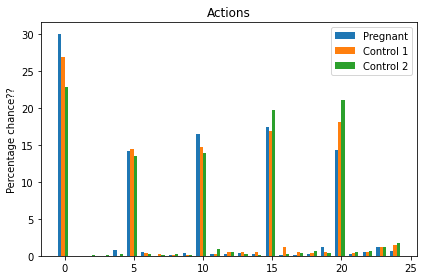

In [42]:
x = np.arange(len(phys_df["actions"]))
width = 0.35  # the width of the bars

fig, axp = plt.subplots()
rects1 = axp.bar(x - width, phys_df["chosen_preg_prob"], width*2/3, label='Pregnant')
rects2 = axp.bar(x - width/3, phys_df["chosen_cont_prob"], width*2/3, label='Control 1')
rects3 = axp.bar(x + width/3, phys_df["chosen_cont_sec_prob"], width*2/3, label='Control 2')

# Add some text for labels, title and custom x-axis tick labels, etc.
axp.set_ylabel('Percentage chance??')
axp.set_title('Actions')
#axp.set_xticks(x, phys_df["actions"])
axp.legend()

#axp.bar_label(rects1, padding=3)
#axp.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [43]:
deeprl2_df.head()

,actions,chosen_preg,chosen_cont,chosen_cont_sec,diff_preg_cont,diff_preg_cont_sec,chosen_preg_prob,chosen_cont_prob,chosen_cont_sec_prob
0,0,0.202869,0.182093,0.167759,-0.020776,-0.035110,20.286885,18.209332,16.775885
1,1,0.000000,0.001261,0.008301,0.001261,0.008301,0.000000,0.126103,0.830057
2,2,0.046107,0.051702,0.020533,0.005596,-0.025574,4.610656,5.170240,2.053298
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.011270,0.006810,0.011796,-0.004461,0.000525,1.127049,0.680958,1.179554


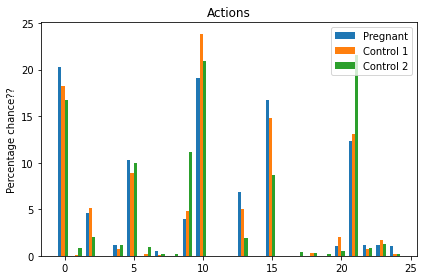

In [44]:
x = np.arange(len(deeprl2_df["actions"]))
width = 0.35  # the width of the bars

fig, axp = plt.subplots()
rects1 = axp.bar(x - width, deeprl2_df["chosen_preg_prob"], width*2/3, label='Pregnant')
rects2 = axp.bar(x - width/3, deeprl2_df["chosen_cont_prob"], width*2/3, label='Control 1')
rects3 = axp.bar(x + width/3, deeprl2_df["chosen_cont_sec_prob"], width*2/3, label='Control 2')

# Add some text for labels, title and custom x-axis tick labels, etc.
axp.set_ylabel('Percentage chance??')
axp.set_title('Actions')
#axp.set_xticks(x, phys_df["actions"])
axp.legend()

#axp.bar_label(rects1, padding=3)
#axp.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

(-0.04, 0.05)

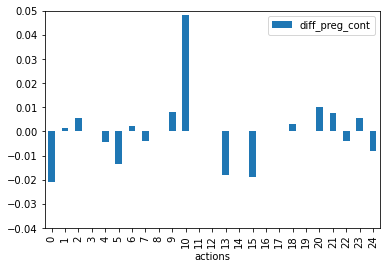

In [45]:
ax1 = deeprl2_df[["actions", "diff_preg_cont"]].plot(x="actions", kind="bar")
ax1.set_ylim(-0.04,0.05)

(-0.04, 0.05)

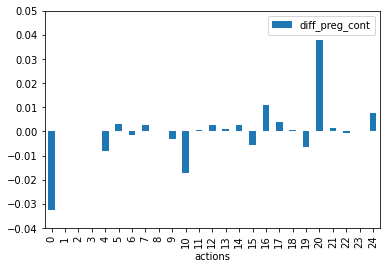

In [46]:
ax2 = phys_df[["actions", "diff_preg_cont"]].plot(x="actions", kind="bar")
ax2.set_ylim(-0.04,0.05)

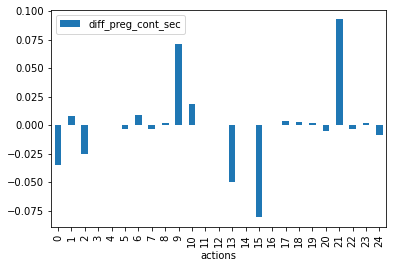

In [47]:
ax3 = deeprl2_df[["actions", "diff_preg_cont_sec"]].plot(x="actions", kind="bar")
#ax3.set_ylim(-0.04,0.05)

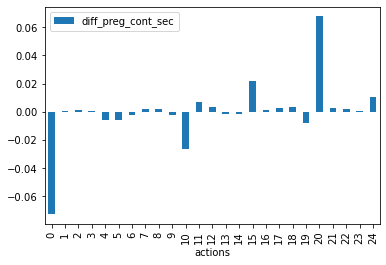

In [48]:
ax4 = phys_df[["actions", "diff_preg_cont_sec"]].plot(x="actions", kind="bar")
#ax4.set_ylim(-0.04,0.05)

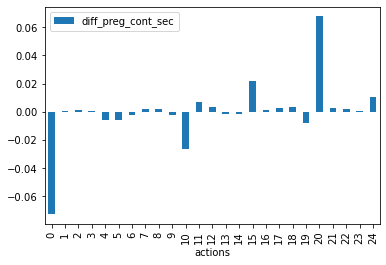

In [49]:
ax5 = phys_df[["actions", "diff_preg_cont_sec"]].plot(x="actions", kind="bar")
#ax3.set_ylim(-0.04,0.05)

<BarContainer object of 25 artists>

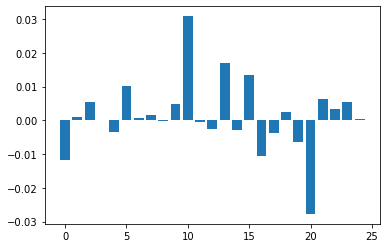

In [50]:
deeprl2_phys_diff_cont = np.subtract([abs(number) for number in list(deeprl2_df["diff_preg_cont"])], [abs(number) for number in list(phys_df["diff_preg_cont"])])
plt.bar([i for i in range(0,25)],deeprl2_phys_diff_cont)

Text(0, 0.5, 'Frequency')

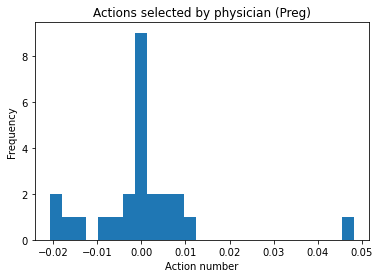

In [51]:
_ = plt.hist(deeprl2_df["diff_preg_cont"], bins=25)
plt.title("Actions selected by physician (Preg)")
plt.xlabel("Action number")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

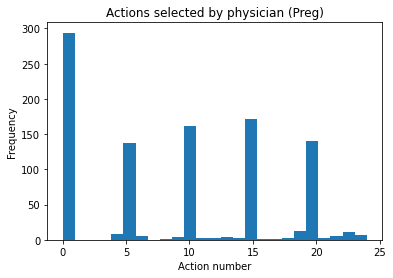

In [52]:
_ = plt.hist(phys_actions_preg, bins=25)
plt.title("Actions selected by physician (Preg)")
#plt.ysize("log")
plt.xlabel("Action number")
plt.ylabel("Frequency")

In [53]:
inv_action_map = {}
count = 0
for i in range(5):
    for j in range(5):
        inv_action_map[count] = [i,j]
        count += 1

In [54]:
phys_actions_tuple_preg = [0 for i in range(len(phys_actions_preg))]
deeprl2_actions_tuple_preg = [0 for i in range(len(deeprl2_actions_preg))]                                      

for i in range(len(phys_actions_preg)):
    #print(deeprl2_actions_preg[i])
    phys_actions_tuple_preg[i] = inv_action_map[phys_actions_preg[i]]
    deeprl2_actions_tuple_preg[i] = inv_action_map[int(deeprl2_actions_preg[i])]

In [55]:
phys_actions_tuple_cont = [None for i in range(len(phys_actions_cont))]
deeprl2_actions_tuple_cont = [None for i in range(len(phys_actions_cont))]                                      

for i in range(len(phys_actions_cont)):
    phys_actions_tuple_cont[i] = inv_action_map[phys_actions_cont[i]]
    deeprl2_actions_tuple_cont[i] = inv_action_map[deeprl2_actions_cont[i]]

In [56]:
phys_actions_tuple_cont_sec = [None for i in range(len(phys_actions_cont_sec))]
deeprl2_actions_tuple_cont_sec = [None for i in range(len(phys_actions_cont_sec))]                                      

for i in range(len(phys_actions_cont_sec)):
    phys_actions_tuple_cont_sec[i] = inv_action_map[phys_actions_cont_sec[i]]
    deeprl2_actions_tuple_cont_sec[i] = inv_action_map[deeprl2_actions_cont_sec[i]]

In [57]:
phys_actions_tuple_old = [0 for i in range(len(phys_actions_old))]
deeprl2_actions_tuple_old = [0 for i in range(len(deeprl2_actions_old))]                                      

for i in range(len(phys_actions_old)):
    #print(deeprl2_actions_preg[i])
    phys_actions_tuple_old[i] = inv_action_map[phys_actions_old[i]]
    deeprl2_actions_tuple_old[i] = inv_action_map[int(deeprl2_actions_old[i])]

In [58]:
phys_actions_tuple_test = [0 for i in range(len(phys_actions_test))]
deeprl2_actions_tuple_test = [0 for i in range(len(deeprl2_actions_test))]                                      

for i in range(len(deeprl2_actions_test)): #len(phys_actions_test)
    #print(deeprl2_actions_preg[i])
    phys_actions_tuple_test[i] = inv_action_map[phys_actions_test[i]]
    deeprl2_actions_tuple_test[i] = inv_action_map[int(deeprl2_actions_test[i])]

In [59]:
len(phys_actions_train)

194904

In [60]:
phys_actions_tuple_train = [0 for i in range(len(phys_actions_train))]
deeprl2_actions_tuple_train = [0 for i in range(len(deeprl2_actions_train))]                                      

for i in range(len(deeprl2_actions_train)): #len(phys_actions_train)
    #print(deeprl2_actions_preg[i])
    phys_actions_tuple_train[i] = inv_action_map[phys_actions_train[i]]
    deeprl2_actions_tuple_train[i] = inv_action_map[int(deeprl2_actions_train[i])]

IndexError: list index out of range

In [61]:
phys_actions_tuple_preg = np.array(phys_actions_tuple_preg)
deeprl2_actions_tuple_preg = np.array(deeprl2_actions_tuple_preg)

phys_actions_tuple_cont = np.array(phys_actions_tuple_cont)
deeprl2_actions_tuple_cont = np.array(deeprl2_actions_tuple_cont)

phys_actions_tuple_cont_sec = np.array(phys_actions_tuple_cont_sec)
deeprl2_actions_tuple_cont_sec = np.array(deeprl2_actions_tuple_cont_sec)

In [62]:
phys_actions_tuple_old = np.array(phys_actions_tuple_old)
deeprl2_actions_tuple_old = np.array(deeprl2_actions_tuple_old)

In [63]:
phys_actions_tuple_test = np.array(phys_actions_tuple_test)
deeprl2_actions_tuple_test = np.array(deeprl2_actions_tuple_test)

C:\Users\sianc\anaconda3\envs\willthiswork\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [64]:
phys_actions_tuple_test

array([list([2, 0]), list([2, 0]), list([2, 0]), ..., 0, 0, 0],
      dtype=object)

In [65]:
phys_actions_tuple_train = np.array(phys_actions_tuple_train)
deeprl2_actions_tuple_train = np.array(deeprl2_actions_tuple_train)

C:\Users\sianc\anaconda3\envs\willthiswork\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [66]:
phys_actions_iv_preg = phys_actions_tuple_preg[:,0]
phys_actions_vaso_preg = phys_actions_tuple_preg[:,1]
hist_preg, x_edges_preg, y_edges_preg = np.histogram2d(phys_actions_iv_preg, phys_actions_vaso_preg, bins=5)

In [67]:
phys_actions_iv_cont = phys_actions_tuple_cont[:,0]
phys_actions_vaso_cont = phys_actions_tuple_cont[:,1]
hist_cont, x_edges_cont, y_edges_cont = np.histogram2d(phys_actions_iv_cont, phys_actions_vaso_cont, bins=5)

In [68]:
phys_actions_iv_cont_sec = phys_actions_tuple_cont_sec[:,0]
phys_actions_vaso_cont_sec = phys_actions_tuple_cont_sec[:,1]
hist_cont_sec, x_edges_cont_sec, y_edges_cont_sec = np.histogram2d(phys_actions_iv_cont_sec, phys_actions_vaso_cont_sec, bins=5)

In [69]:
phys_actions_iv_old = phys_actions_tuple_old[:,0]
phys_actions_vaso_old = phys_actions_tuple_old[:,1]
hist_old, x_edges_old, y_edges_old = np.histogram2d(phys_actions_iv_old, phys_actions_vaso_old, bins=5)

In [70]:
phys_actions_iv_test = phys_actions_tuple_test[:,0]
phys_actions_vaso_test = phys_actions_tuple_test[:,1]
hist_test, x_edges_test, y_edges_test = np.histogram2d(phys_actions_iv_test, phys_actions_vaso_test, bins=5)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [71]:
phys_actions_iv_train = phys_actions_tuple_train[:,0]
phys_actions_vaso_train = phys_actions_tuple_train[:,1]
hist_train, x_edges_train, y_edges_train = np.histogram2d(phys_actions_iv_train, phys_actions_vaso_train, bins=5)

In [72]:
deeprl2_actions_iv_preg = deeprl2_actions_tuple_preg[:,0]
deeprl2_actions_vaso_preg = deeprl2_actions_tuple_preg[:,1]
hist2_preg, _, _ = np.histogram2d(deeprl2_actions_iv_preg, deeprl2_actions_vaso_preg, bins=5)

In [73]:
deeprl2_actions_iv_cont = deeprl2_actions_tuple_cont[:,0]
deeprl2_actions_vaso_cont = deeprl2_actions_tuple_cont[:,1]
hist2_cont, _, _ = np.histogram2d(deeprl2_actions_iv_cont, deeprl2_actions_vaso_cont, bins=5)

In [74]:
deeprl2_actions_iv_cont_sec = deeprl2_actions_tuple_cont_sec[:,0]
deeprl2_actions_vaso_cont_sec = deeprl2_actions_tuple_cont_sec[:,1]
hist2_cont_sec, _, _ = np.histogram2d(deeprl2_actions_iv_cont_sec, deeprl2_actions_vaso_cont_sec, bins=5)

In [75]:
deeprl2_actions_iv_old = deeprl2_actions_tuple_old[:,0]
deeprl2_actions_vaso_old = deeprl2_actions_tuple_old[:,1]
hist2_old, _, _ = np.histogram2d(deeprl2_actions_iv_old, deeprl2_actions_vaso_old, bins=5)

In [76]:
deeprl2_actions_iv_test = deeprl2_actions_tuple_test[:,0]
deeprl2_actions_vaso_test = deeprl2_actions_tuple_test[:,1]
hist2_test, _, _ = np.histogram2d(deeprl2_actions_iv_test, deeprl2_actions_vaso_test, bins=5)

In [77]:
deeprl2_actions_iv_train = deeprl2_actions_tuple_train[:,0]
deeprl2_actions_vaso_train = deeprl2_actions_tuple_train[:,1]
hist2_train, _, _ = np.histogram2d(deeprl2_actions_iv_train, deeprl2_actions_vaso_train, bins=5)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [78]:
x_edges_preg = np.arange(-0.5,5)
y_edges_preg = np.arange(-0.5,5)

x_edges_cont = np.arange(-0.5,5)
y_edges_cont = np.arange(-0.5,5)

x_edges_cont_sec = np.arange(-0.5,5)
y_edges_cont_sec = np.arange(-0.5,5)

In [79]:
x_edges_old = np.arange(-0.5,5)
y_edges_old = np.arange(-0.5,5)

In [80]:
x_edges_test = np.arange(-0.5,5)
y_edges_test = np.arange(-0.5,5)

In [81]:
x_edges_train = np.arange(-0.5,5)
y_edges_train = np.arange(-0.5,5)

In [82]:
phys_actions_iv_old = phys_actions_tuple_old[:,0]
phys_actions_vaso_old = phys_actions_tuple_old[:,1]
hist_old, x_edges_old, y_edges_old = np.histogram2d(phys_actions_iv_old, phys_actions_vaso_old, bins=5)

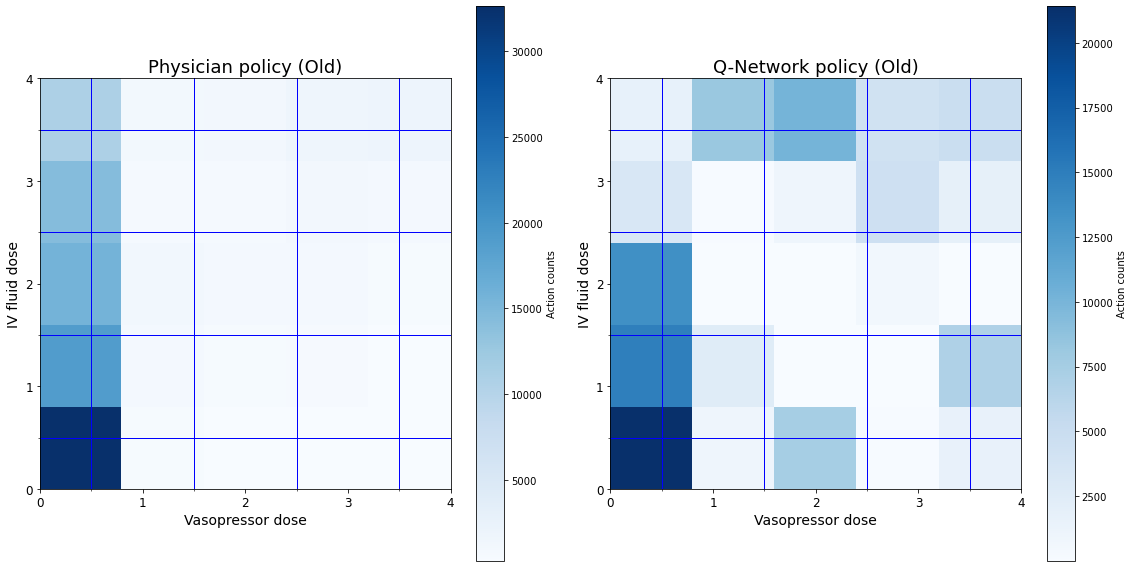

In [83]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.imshow(np.flipud(hist_old), cmap="Blues",extent=[x_edges_old[0], x_edges_old[-1],  y_edges_old[0],y_edges_old[-1]])
ax2.imshow(np.flipud(hist2_old), cmap="Blues", extent=[x_edges_old[0], x_edges_old[-1],  y_edges_old[0],y_edges_old[-1]])

# Major ticks
ax1.set_xticks(np.arange(0, 5, 1));
ax1.set_yticks(np.arange(0, 5, 1));
ax2.set_xticks(np.arange(0, 5, 1));
ax2.set_yticks(np.arange(0, 5, 1));

# Labels for major ticks
ax1.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
ax1.set_yticklabels(np.arange(0, 5, 1), fontsize=12);
ax2.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
ax2.set_yticklabels(np.arange(0, 5, 1), fontsize=12);

# Minor ticks
ax1.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax1.set_yticks(np.arange(-.5, 5, 1), minor=True);
ax2.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax2.set_yticks(np.arange(-.5, 5, 1), minor=True);

# Gridlines based on minor ticks
ax1.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax2.grid(which='minor', color='b', linestyle='-', linewidth=1)


im1 = ax1.pcolormesh(x_edges_old, y_edges_old, hist_old, cmap='Blues')
f.colorbar(im1, ax=ax1, label = "Action counts")

im2 = ax2.pcolormesh(x_edges_old, y_edges_old, hist2_old, cmap='Blues')
f.colorbar(im2, ax=ax2, label = "Action counts")

ax1.set_ylabel('IV fluid dose', fontsize=14)
ax2.set_ylabel('IV fluid dose', fontsize=14)

ax1.set_xlabel('Vasopressor dose', fontsize=14)
ax2.set_xlabel('Vasopressor dose', fontsize=14)

ax1.set_title("Physician policy (Old)", fontsize=18)
ax2.set_title("Q-Network policy (Old)", fontsize=18)


plt.tight_layout()

C:\Users\sianc\anaconda3\envs\willthiswork\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log
C:\Users\sianc\anaconda3\envs\willthiswork\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log
C:\Users\sianc\anaconda3\envs\willthiswork\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in log
C:\Users\sianc\anaconda3\envs\willthiswork\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log
C:\Users\sianc\anaconda3\envs\willthiswork\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in log


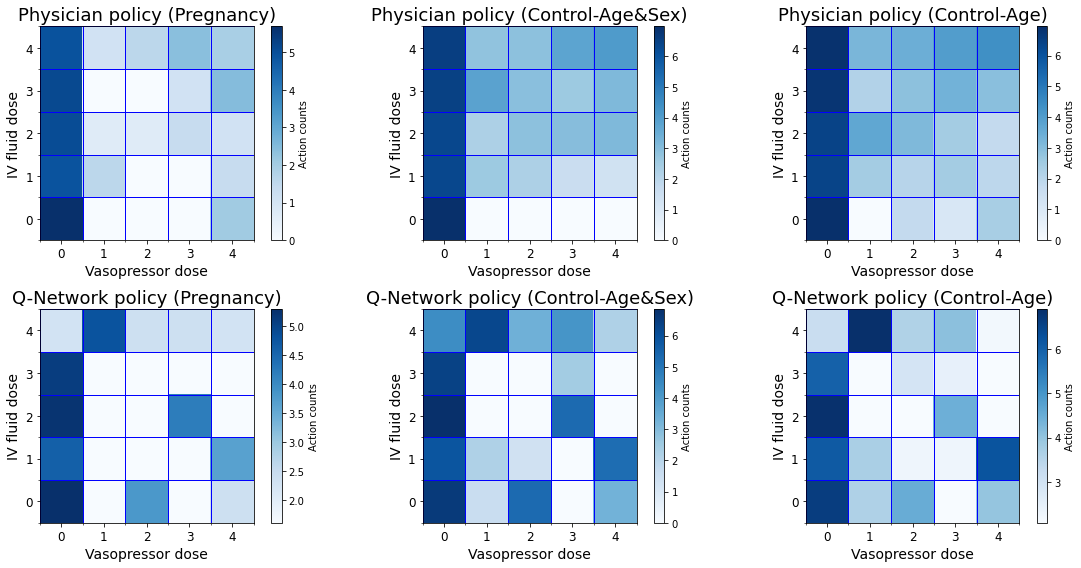

In [84]:
f, ((ax1, ax3, ax5), (ax2, ax4, ax6)) = plt.subplots(2, 3, figsize=(16,8))
ax1.imshow(np.flipud(hist_preg), cmap="Blues",extent=[x_edges_preg[0], x_edges_preg[-1],  y_edges_preg[0],y_edges_preg[-1]])
ax2.imshow(np.flipud(hist2_preg), cmap="Blues", extent=[x_edges_preg[0], x_edges_preg[-1],  y_edges_preg[0],y_edges_preg[-1]])
ax3.imshow(np.flipud(hist_cont), cmap="Blues",extent=[x_edges_cont[0], x_edges_cont[-1],  y_edges_cont[0],y_edges_cont[-1]])
ax4.imshow(np.flipud(hist2_cont), cmap="Blues", extent=[x_edges_cont[0], x_edges_cont[-1],  y_edges_cont[0],y_edges_cont[-1]])
ax5.imshow(np.flipud(hist_cont_sec), cmap="Blues",extent=[x_edges_cont_sec[0], x_edges_cont_sec[-1],  y_edges_cont_sec[0],y_edges_cont_sec[-1]])
ax6.imshow(np.flipud(hist2_cont_sec), cmap="Blues", extent=[x_edges_cont_sec[0], x_edges_cont_sec[-1],  y_edges_cont_sec[0],y_edges_cont_sec[-1]])

# ax1.grid(color='b', linestyle='-', linewidth=1)
# ax2.grid(color='r', linestyle='-', linewidth=1)
# ax3.grid(color='g', linestyle='-', linewidth=1)

# Major ticks
ax1.set_xticks(np.arange(0, 5, 1));
ax1.set_yticks(np.arange(0, 5, 1));
ax2.set_xticks(np.arange(0, 5, 1));
ax2.set_yticks(np.arange(0, 5, 1));
ax3.set_xticks(np.arange(0, 5, 1));
ax3.set_yticks(np.arange(0, 5, 1));
ax4.set_xticks(np.arange(0, 5, 1));
ax4.set_yticks(np.arange(0, 5, 1));
ax5.set_xticks(np.arange(0, 5, 1));
ax5.set_yticks(np.arange(0, 5, 1));
ax6.set_xticks(np.arange(0, 5, 1));
ax6.set_yticks(np.arange(0, 5, 1));

# Labels for major ticks
ax1.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
ax1.set_yticklabels(np.arange(0, 5, 1), fontsize=12);
ax2.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
ax2.set_yticklabels(np.arange(0, 5, 1), fontsize=12);
ax3.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
ax3.set_yticklabels(np.arange(0, 5, 1), fontsize=12);
ax4.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
ax4.set_yticklabels(np.arange(0, 5, 1), fontsize=12);
ax5.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
ax5.set_yticklabels(np.arange(0, 5, 1), fontsize=12);
ax6.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
ax6.set_yticklabels(np.arange(0, 5, 1), fontsize=12);

# Minor ticks
ax1.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax1.set_yticks(np.arange(-.5, 5, 1), minor=True);
ax2.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax2.set_yticks(np.arange(-.5, 5, 1), minor=True);
ax3.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax3.set_yticks(np.arange(-.5, 5, 1), minor=True);
ax4.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax4.set_yticks(np.arange(-.5, 5, 1), minor=True);
ax5.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax5.set_yticks(np.arange(-.5, 5, 1), minor=True);
ax6.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax6.set_yticks(np.arange(-.5, 5, 1), minor=True);

# Gridlines based on minor ticks
ax1.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax2.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax3.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax4.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax5.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax6.grid(which='minor', color='b', linestyle='-', linewidth=1)

im1 = ax1.pcolormesh(x_edges_preg, y_edges_preg, np.log(hist_preg), cmap='Blues')
f.colorbar(im1, ax=ax1, label = "Action counts")

im2 = ax2.pcolormesh(x_edges_preg, y_edges_preg, np.log(hist2_preg), cmap='Blues')
f.colorbar(im2, ax=ax2, label = "Action counts")

im3 = ax3.pcolormesh(x_edges_cont, y_edges_cont, np.log(hist_cont), cmap='Blues')
f.colorbar(im3, ax=ax3, label = "Action counts")

im4 = ax4.pcolormesh(x_edges_cont, y_edges_cont, np.log(hist2_cont), cmap='Blues')
f.colorbar(im4, ax=ax4, label = "Action counts")

im5 = ax5.pcolormesh(x_edges_cont_sec, y_edges_cont_sec, np.log(hist_cont_sec), cmap='Blues')
f.colorbar(im5, ax=ax5, label = "Action counts")

im6 = ax6.pcolormesh(x_edges_cont_sec, y_edges_cont_sec, np.log(hist2_cont_sec), cmap='Blues')
f.colorbar(im6, ax=ax6, label = "Action counts")



ax1.set_ylabel('IV fluid dose', fontsize=14)
ax2.set_ylabel('IV fluid dose', fontsize=14)
ax3.set_ylabel('IV fluid dose', fontsize=14)
ax4.set_ylabel('IV fluid dose', fontsize=14)
ax5.set_ylabel('IV fluid dose', fontsize=14)
ax6.set_ylabel('IV fluid dose', fontsize=14)
ax1.set_xlabel('Vasopressor dose', fontsize=14)
ax2.set_xlabel('Vasopressor dose', fontsize=14)
ax3.set_xlabel('Vasopressor dose', fontsize=14)
ax4.set_xlabel('Vasopressor dose', fontsize=14)
ax5.set_xlabel('Vasopressor dose', fontsize=14)
ax6.set_xlabel('Vasopressor dose', fontsize=14)

ax1.set_title("Physician policy (Pregnancy)", fontsize=18)
ax2.set_title("Q-Network policy (Pregnancy)", fontsize=18)
ax3.set_title("Physician policy (Control-Age&Sex)", fontsize=18)
ax4.set_title("Q-Network policy (Control-Age&Sex)", fontsize=18)
ax5.set_title("Physician policy (Control-Age)", fontsize=18)
ax6.set_title("Q-Network policy (Control-Age)", fontsize=18)
plt.tight_layout()

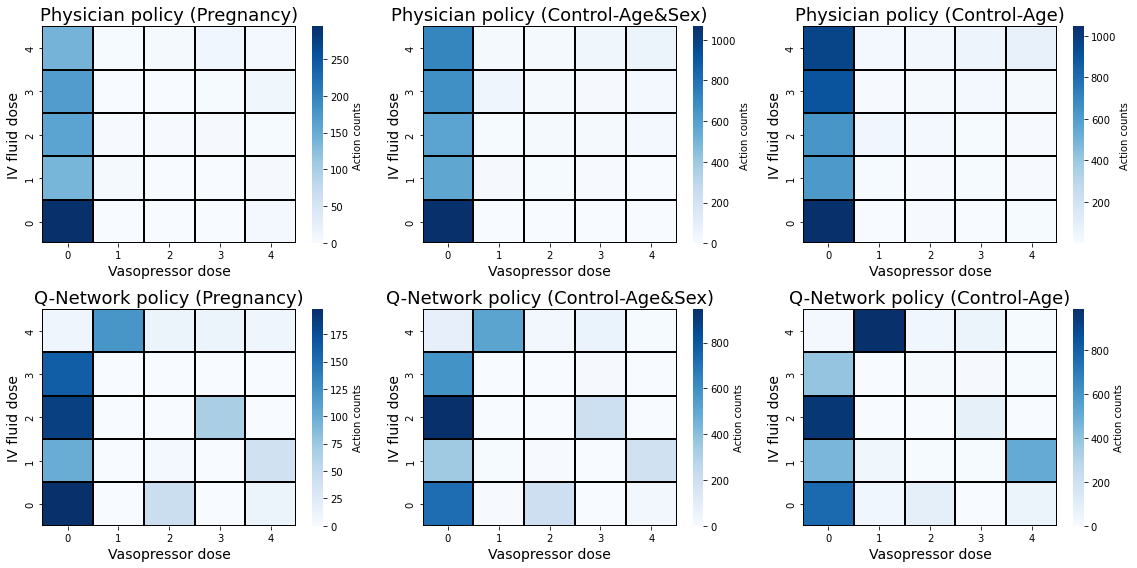

In [85]:
f, ((ax1, ax3, ax5), (ax2, ax4, ax6)) = plt.subplots(2, 3, figsize=(16,8))

import seaborn as sns
sns.heatmap(np.flipud(hist_preg), cmap='Blues', ax=ax1, fmt='g', linewidths=1, linecolor='Black', yticklabels=[4,3,2,1,0], cbar_kws={'label': 'Action counts'})
sns.heatmap(np.flipud(hist2_preg), cmap='Blues', ax=ax2, fmt='g', linewidths=1, linecolor='Black', yticklabels=[4,3,2,1,0], cbar_kws={'label': 'Action counts'})
sns.heatmap(np.flipud(hist_cont), cmap='Blues', ax=ax3, fmt='g', linewidths=1, linecolor='Black', yticklabels=[4,3,2,1,0], cbar_kws={'label': 'Action counts'})
sns.heatmap(np.flipud(hist2_cont), cmap='Blues', ax=ax4, fmt='g', linewidths=1, linecolor='Black', yticklabels=[4,3,2,1,0], cbar_kws={'label': 'Action counts'})
sns.heatmap(np.flipud(hist_cont_sec), cmap='Blues', ax=ax5, fmt='g', linewidths=1, linecolor='Black', yticklabels=[4,3,2,1,0], cbar_kws={'label': 'Action counts'})
sns.heatmap(np.flipud(hist2_cont_sec), cmap='Blues', ax=ax6, fmt='g', linewidths=1, linecolor='Black', yticklabels=[4,3,2,1,0], cbar_kws={'label': 'Action counts'})

#ax1.grid(color='b', linestyle='-', linewidth=1)
# ax2.grid(color='r', linestyle='-', linewidth=1)
# ax3.grid(color='g', linestyle='-', linewidth=1)

# #Major ticks
# ax1.set_xticks(np.arange(0, 5, 1));
# ax1.set_yticks(np.arange(0, 5, 1));
# ax2.set_xticks(np.arange(0, 5, 1));
# ax2.set_yticks(np.arange(0, 5, 1));
# ax3.set_xticks(np.arange(0, 5, 1));
# ax3.set_yticks(np.arange(0, 5, 1));
# ax4.set_xticks(np.arange(0, 5, 1));
# ax4.set_yticks(np.arange(0, 5, 1));
# ax5.set_xticks(np.arange(0, 5, 1));
# ax5.set_yticks(np.arange(0, 5, 1));
# ax6.set_xticks(np.arange(0, 5, 1));
# ax6.set_yticks(np.arange(0, 5, 1));

# # Labels for major ticks
# ax1.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
# ax1.set_yticklabels(np.arange(5, 0, 1), fontsize=12);
# ax2.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
# ax2.set_yticklabels(np.arange(0, 5, 1), fontsize=12);
# ax3.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
# ax3.set_yticklabels(np.arange(0, 5, 1), fontsize=12);
# ax4.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
# ax4.set_yticklabels(np.arange(0, 5, 1), fontsize=12);
# ax5.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
# ax5.set_yticklabels(np.arange(0, 5, 1), fontsize=12);
# ax6.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
# ax6.set_yticklabels(np.arange(0, 5, 1), fontsize=12);

# # Minor ticks
# ax1.set_xticks(np.arange(-.5, 5, 1), minor=True);
# ax1.set_yticks(np.arange(-.5, 5, 1), minor=True);
# ax2.set_xticks(np.arange(-.5, 5, 1), minor=True);
# ax2.set_yticks(np.arange(-.5, 5, 1), minor=True);
# ax3.set_xticks(np.arange(-.5, 5, 1), minor=True);
# ax3.set_yticks(np.arange(-.5, 5, 1), minor=True);
# ax4.set_xticks(np.arange(-.5, 5, 1), minor=True);
# ax4.set_yticks(np.arange(-.5, 5, 1), minor=True);
# ax5.set_xticks(np.arange(-.5, 5, 1), minor=True);
# ax5.set_yticks(np.arange(-.5, 5, 1), minor=True);
# ax6.set_xticks(np.arange(-.5, 5, 1), minor=True);
# ax6.set_yticks(np.arange(-.5, 5, 1), minor=True);

# Gridlines based on minor ticks
ax1.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax2.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax3.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax4.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax5.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax6.grid(which='minor', color='b', linestyle='-', linewidth=1)

# im1 = ax1.pcolormesh(x_edges_preg, y_edges_preg, np.log(hist_preg), cmap='Blues')
# f.colorbar(im1, ax=ax1, label = "Action counts")

# im2 = ax2.pcolormesh(x_edges_preg, y_edges_preg, np.log(hist2_preg), cmap='Blues')
# f.colorbar(im2, ax=ax2, label = "Action counts")

# im3 = ax3.pcolormesh(x_edges_cont, y_edges_cont, np.log(hist_cont), cmap='Blues')
# f.colorbar(im3, ax=ax3, label = "Action counts")

# im4 = ax4.pcolormesh(x_edges_cont, y_edges_cont, np.log(hist2_cont), cmap='Blues')
# f.colorbar(im4, ax=ax4, label = "Action counts")

# im5 = ax5.pcolormesh(x_edges_cont_sec, y_edges_cont_sec, np.log(hist_cont_sec), cmap='Blues')
# f.colorbar(im5, ax=ax5, label = "Action counts")

# im6 = ax6.pcolormesh(x_edges_cont_sec, y_edges_cont_sec, np.log(hist2_cont_sec), cmap='Blues')
# f.colorbar(im6, ax=ax6, label = "Action counts")



ax1.set_ylabel('IV fluid dose', fontsize=14)
ax2.set_ylabel('IV fluid dose', fontsize=14)
ax3.set_ylabel('IV fluid dose', fontsize=14)
ax4.set_ylabel('IV fluid dose', fontsize=14)
ax5.set_ylabel('IV fluid dose', fontsize=14)
ax6.set_ylabel('IV fluid dose', fontsize=14)
ax1.set_xlabel('Vasopressor dose', fontsize=14)
ax2.set_xlabel('Vasopressor dose', fontsize=14)
ax3.set_xlabel('Vasopressor dose', fontsize=14)
ax4.set_xlabel('Vasopressor dose', fontsize=14)
ax5.set_xlabel('Vasopressor dose', fontsize=14)
ax6.set_xlabel('Vasopressor dose', fontsize=14)

ax1.set_title("Physician policy (Pregnancy)", fontsize=18)
ax2.set_title("Q-Network policy (Pregnancy)", fontsize=18)
ax3.set_title("Physician policy (Control-Age&Sex)", fontsize=18)
ax4.set_title("Q-Network policy (Control-Age&Sex)", fontsize=18)
ax5.set_title("Physician policy (Control-Age)", fontsize=18)
ax6.set_title("Q-Network policy (Control-Age)", fontsize=18)
plt.tight_layout()

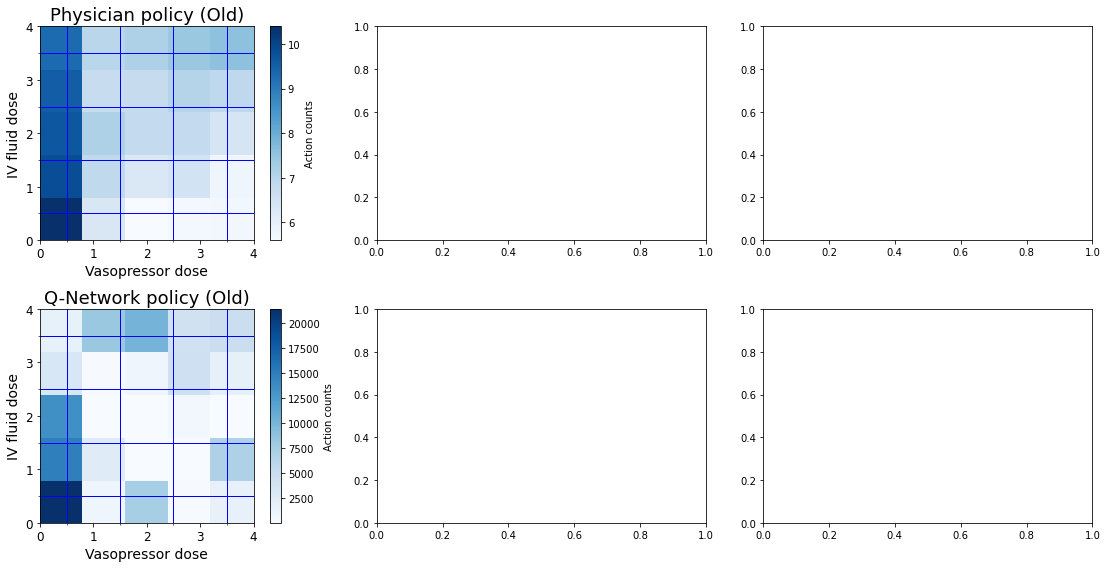

In [86]:
f, ((ax1, ax3, ax5), (ax2, ax4, ax6)) = plt.subplots(2, 3, figsize=(16,8))
ax1.imshow(np.flipud(hist_old), cmap="Blues",extent=[x_edges_old[0], x_edges_old[-1],  y_edges_old[0],y_edges_old[-1]])
ax2.imshow(np.flipud(hist2_old), cmap="Blues", extent=[x_edges_old[0], x_edges_old[-1],  y_edges_old[0],y_edges_old[-1]])
#ax3.imshow(np.flipud(hist_test), cmap="Blues",extent=[x_edges_test[0], x_edges_test[-1],  y_edges_test[0],y_edges_test[-1]])
#ax4.imshow(np.flipud(hist2_test), cmap="Blues", extent=[x_edges_test[0], x_edges_test[-1],  y_edges_test[0],y_edges_test[-1]])
#ax5.imshow(np.flipud(hist_train), cmap="Blues",extent=[x_edges_train[0], x_edges_train[-1],  y_edges_train[0],y_edges_train[-1]])
#ax5.imshow(np.flipud(hist2_train), cmap="Blues", extent=[x_edges_train[0], x_edges_train[-1],  y_edges_train[0],y_edges_train[-1]])
# ax1.grid(color='b', linestyle='-', linewidth=1)
# ax2.grid(color='r', linestyle='-', linewidth=1)
# ax3.grid(color='g', linestyle='-', linewidth=1)

# Major ticks
ax1.set_xticks(np.arange(0, 5, 1));
ax1.set_yticks(np.arange(0, 5, 1));
ax2.set_xticks(np.arange(0, 5, 1));
ax2.set_yticks(np.arange(0, 5, 1));
#ax3.set_xticks(np.arange(0, 5, 1));
#ax3.set_yticks(np.arange(0, 5, 1));
#ax4.set_xticks(np.arange(0, 5, 1));
#ax4.set_yticks(np.arange(0, 5, 1));
#ax5.set_xticks(np.arange(0, 5, 1));
#ax5.set_yticks(np.arange(0, 5, 1));
#ax6.set_xticks(np.arange(0, 5, 1));
#ax6.set_yticks(np.arange(0, 5, 1));


# Labels for major ticks
ax1.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
ax1.set_yticklabels(np.arange(0, 5, 1), fontsize=12);
ax2.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
ax2.set_yticklabels(np.arange(0, 5, 1), fontsize=12);
#ax3.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
#ax3.set_yticklabels(np.arange(0, 5, 1), fontsize=12);
#ax4.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
#ax4.set_yticklabels(np.arange(0, 5, 1), fontsize=12);
#ax5.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
#ax5.set_yticklabels(np.arange(0, 5, 1), fontsize=12);
#ax6.set_xticklabels(np.arange(0, 5, 1), fontsize=12);
#ax6.set_yticklabels(np.arange(0, 5, 1), fontsize=12);


# Minor ticks
ax1.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax1.set_yticks(np.arange(-.5, 5, 1), minor=True);
ax2.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax2.set_yticks(np.arange(-.5, 5, 1), minor=True);
#ax3.set_xticks(np.arange(-.5, 5, 1), minor=True);
#ax3.set_yticks(np.arange(-.5, 5, 1), minor=True);
#ax4.set_xticks(np.arange(-.5, 5, 1), minor=True);
#ax4.set_yticks(np.arange(-.5, 5, 1), minor=True);
#ax5.set_xticks(np.arange(-.5, 5, 1), minor=True);
#ax5.set_yticks(np.arange(-.5, 5, 1), minor=True);
#ax6.set_xticks(np.arange(-.5, 5, 1), minor=True);
#ax6.set_yticks(np.arange(-.5, 5, 1), minor=True);


# Gridlines based on minor ticks
ax1.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax2.grid(which='minor', color='b', linestyle='-', linewidth=1)
#ax3.grid(which='minor', color='b', linestyle='-', linewidth=1)
#ax4.grid(which='minor', color='b', linestyle='-', linewidth=1)
#ax5.grid(which='minor', color='b', linestyle='-', linewidth=1)
#ax6.grid(which='minor', color='b', linestyle='-', linewidth=1)

im1 = ax1.pcolormesh(x_edges_old, y_edges_old, np.log(hist_old), cmap='Blues')
f.colorbar(im1, ax=ax1, label = "Action counts")

im2 = ax2.pcolormesh(x_edges_old, y_edges_old, hist2_old, cmap='Blues')
f.colorbar(im2, ax=ax2, label = "Action counts")

#im3 = ax3.pcolormesh(x_edges_test, y_edges_test, hist_test, cmap='Blues')
#f.colorbar(im3, ax=ax3, label = "Action counts")

#im4 = ax4.pcolormesh(x_edges_test, y_edges_test, hist2_test, cmap='Blues')
#f.colorbar(im4, ax=ax4, label = "Action counts")

#im5 = ax5.pcolormesh(x_edges_train, y_edges_train, hist_train, cmap='Blues')
#f.colorbar(im5, ax=ax5, label = "Action counts")

#im6 = ax6.pcolormesh(x_edges_train, y_edges_train, hist2_train, cmap='Blues')
#f.colorbar(im6, ax=ax6, label = "Action counts")



ax1.set_ylabel('IV fluid dose', fontsize=14)
ax2.set_ylabel('IV fluid dose', fontsize=14)
#ax3.set_ylabel('IV fluid dose', fontsize=14)
#ax4.set_ylabel('IV fluid dose', fontsize=14)
#ax5.set_ylabel('IV fluid dose', fontsize=14)
#ax6.set_ylabel('IV fluid dose', fontsize=14)

ax1.set_xlabel('Vasopressor dose', fontsize=14)
ax2.set_xlabel('Vasopressor dose', fontsize=14)
#ax3.set_xlabel('Vasopressor dose', fontsize=14)
#ax4.set_xlabel('Vasopressor dose', fontsize=14)
#ax5.set_xlabel('Vasopressor dose', fontsize=14)
#ax6.set_xlabel('Vasopressor dose', fontsize=14)


ax1.set_title("Physician policy (Old)", fontsize=18)
ax2.set_title("Q-Network policy (Old)", fontsize=18)
#ax3.set_title("Physician policy (Test)", fontsize=18)
#ax4.set_title("Q-Network policy (Test)", fontsize=18)
#ax5.set_title("Physician policy (Train)", fontsize=18)
#ax6.set_title("Q-Network policy (Train)", fontsize=18)

plt.tight_layout()

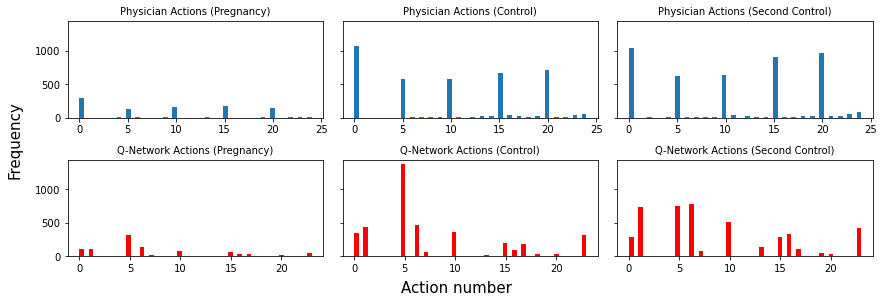

In [73]:
f, ((ax1, ax3, ax5), (ax2, ax4, ax6)) = plt.subplots(2, 3, sharey=True, figsize=(12,4))
ax1.hist(phys_actions_preg, bins=50)
ax1.set_title("Physician Actions (Pregnancy)", fontsize = 10)
ax2.hist(deeprl2_actions_preg, bins=50, color='r')
ax2.set_title("Q-Network Actions (Pregnancy)", fontsize = 10)
ax3.hist(phys_actions_cont, bins=50)
ax3.set_title("Physician Actions (Control)", fontsize = 10)
ax4.hist(deeprl2_actions_cont, bins=50, color='r')
ax4.set_title("Q-Network Actions (Control)", fontsize = 10)
ax5.hist(phys_actions_cont_sec, bins=50)
ax5.set_title("Physician Actions (Second Control)", fontsize = 10)
ax6.hist(deeprl2_actions_cont_sec, bins=50, color='r')
ax6.set_title("Q-Network Actions (Second Control)", fontsize = 10)
f.text(0.5, -0.03, 'Action number', ha='center', fontsize=15)
f.text(-0.02, 0.5, 'Frequency', va='center', rotation='vertical', fontsize = 15)
# ax2.hist(autoencode_actions, bins=25, color ='g')
plt.tight_layout()

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(12,4))
ax1.hist(phys_actions_old, bins=50)
ax1.set_title("Physician Actions (Old)", fontsize = 10)
ax2.hist(deeprl2_actions_old, bins=50, color='r')
ax2.set_title("Q-Network Actions (Old)", fontsize = 10)

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(12,4))
ax1.hist(phys_actions_test, bins=50)
ax1.set_title("Physician Actions (Test)", fontsize = 10)
ax2.hist(deeprl2_actions_test, bins=50, color='r')
ax2.set_title("Q-Network Actions (Test)", fontsize = 10)

Text(0.5, 1.0, 'Q-Network Actions (Train)')

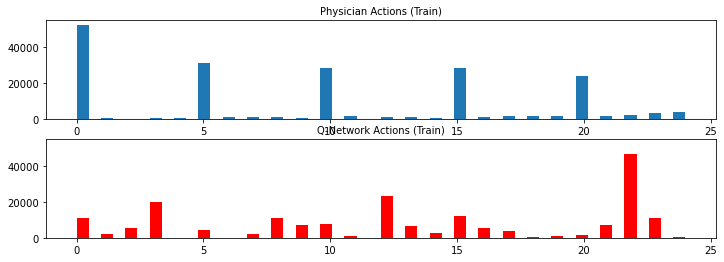

In [72]:
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(12,4))
ax1.hist(phys_actions_train, bins=50)
ax1.set_title("Physician Actions (Train)", fontsize = 10)
ax2.hist(deeprl2_actions_train, bins=50, color='r')
ax2.set_title("Q-Network Actions (Train)", fontsize = 10)

In [100]:
def make_df_diff(op_actions, df):
    op_vaso_med = []
    op_iv_med = []
    for action in op_actions:
        iv,vaso = inv_action_map[action]
        op_vaso_med.append(vaso_vals[vaso])
        op_iv_med.append(iv_vals[iv])
    iv_diff = np.array(op_iv_med) - np.array(df['input_4hourly'])
    vaso_diff = np.array(op_vaso_med) - np.array(df['max_dose_vaso'])
    df_diff = pd.DataFrame()
    df_diff['mort'] = np.array(df['mortality_90d'])
    df_diff['iv_diff'] = iv_diff
    df_diff['vaso_diff'] = vaso_diff
    return df_diff

In [101]:
from scipy.stats import sem
def make_iv_plot_data(df_diff):
    bin_medians_iv = []
    mort_iv = []
    mort_std_iv= []
    i = -800
    while i <= 900:
        count =df_diff.loc[(df_diff['iv_diff']>i-50) & (df_diff['iv_diff']<i+50)]
        try:
            res = sum(count['mort'])/float(len(count))
            if len(count) >=2:
                bin_medians_iv.append(i)
                mort_iv.append(res)
                mort_std_iv.append(sem(count['mort']))
        except ZeroDivisionError:
            pass
        i += 100
    return bin_medians_iv, mort_iv, mort_std_iv

ModuleNotFoundError: No module named 'scipy'

In [44]:
from scipy.stats import sem
def make_vaso_plot_data(df_diff):
    bin_medians_vaso = []
    mort_vaso= []
    mort_std_vaso= []
    i = -0.6
    while i <= 0.8:
        count =df_diff.loc[(df_diff['vaso_diff']>i-0.05) & (df_diff['vaso_diff']<i+0.05)]
        try:
            res = sum(count['mort'])/float(len(count))
            if len(count) >=2:
                bin_medians_vaso.append(i)
                mort_vaso.append(res)
                mort_std_vaso.append(sem(count['mort']))
        except ZeroDivisionError:
            pass
        i += 0.1
    return bin_medians_vaso, mort_vaso, mort_std_vaso

In [45]:
len(deeprl2_actions_preg)

976

In [46]:
len(df_preg_orig)

976

In [47]:
df_preg_orig["mortality_90d"].nunique()

2

In [102]:
df_diff_deeprl2_preg = make_df_diff(deeprl2_actions_preg, df_preg_orig)
df_diff_deeprl2_cont = make_df_diff(deeprl2_actions_cont, df_cont_orig)
df_diff_deeprl2_cont_sec = make_df_diff(deeprl2_actions_cont_sec, df_cont_sec_orig)

In [103]:
bin_med_iv_deep_preg, mort_iv_deep_preg, mort_std_iv_deep_preg = make_iv_plot_data(df_diff_deeprl2_preg)
bin_med_vaso_deep_preg, mort_vaso_deep_preg, mort_std_vaso_deep_preg = make_vaso_plot_data(df_diff_deeprl2_preg)

bin_med_iv_deep_cont, mort_iv_deep_cont, mort_std_iv_deep_cont = make_iv_plot_data(df_diff_deeprl2_cont)
bin_med_vaso_deep_cont, mort_vaso_deep_cont, mort_std_vaso_deep_cont = make_vaso_plot_data(df_diff_deeprl2_cont)

bin_med_iv_deep_cont_sec, mort_iv_deep_cont_sec, mort_std_iv_deep_cont_sec = make_iv_plot_data(df_diff_deeprl2_cont_sec)
bin_med_vaso_deep_cont_sec, mort_vaso_deep_cont_sec, mort_std_vaso_deep_cont_sec = make_vaso_plot_data(df_diff_deeprl2_cont_sec)

NameError: name 'make_iv_plot_data' is not defined

In [104]:
print(mort_iv_deep_preg)

NameError: name 'mort_iv_deep_preg' is not defined

Text(-0.02, 0.5, 'Observed Mortality')

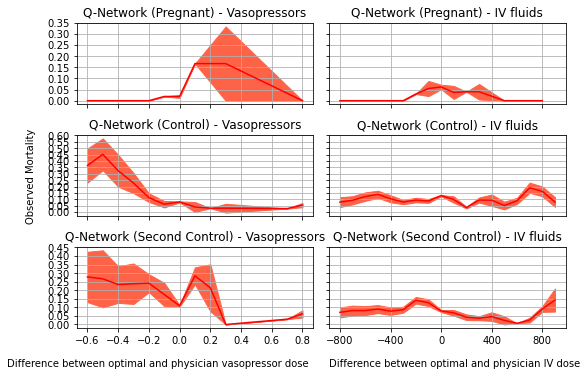

In [51]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex='col', sharey='row', figsize = (7.5,5))
ax1.plot(bin_med_vaso_deep_preg, sliding_mean(mort_vaso_deep_preg), color='r')
ax1.fill_between(bin_med_vaso_deep_preg, sliding_mean(mort_vaso_deep_preg) - 1*mort_std_vaso_deep_preg,  
                 sliding_mean(mort_vaso_deep_preg) + 1*mort_std_vaso_deep_preg, color='tomato')
ax1.set_title('Q-Network (Pregnant) - Vasopressors')
x_r = [i/10.0 for i in range(-6,10,2)]
y_r = [i/20.0 for i in range(0,20,1)]
ax1.set_xticks(x_r)
ax1.set_yticks(y_r)
ax1.grid()

ax2.plot(bin_med_iv_deep_preg, sliding_mean(mort_iv_deep_preg), color='r')
ax2.fill_between(bin_med_iv_deep_preg, sliding_mean(mort_iv_deep_preg) - 1*mort_std_iv_deep_preg,  
                 sliding_mean(mort_iv_deep_preg) + 1*mort_std_iv_deep_preg, color='tomato')
ax2.set_title('Q-Network (Pregnant) - IV fluids')
x_iv = [i for i in range(-800,900,400)]
ax2.set_xticks(x_iv)
ax2.grid()

ax3.plot(bin_med_vaso_deep_cont, sliding_mean(mort_vaso_deep_cont), color='r')
ax3.fill_between(bin_med_vaso_deep_cont, sliding_mean(mort_vaso_deep_cont) - 1*mort_std_vaso_deep_cont,  
                 sliding_mean(mort_vaso_deep_cont) + 1*mort_std_vaso_deep_cont, color='tomato')
ax3.set_title('Q-Network (Control) - Vasopressors')
x_r = [i/10.0 for i in range(-6,10,2)]
y_r = [i/20.0 for i in range(0,20,1)]
ax3.set_xticks(x_r)
ax3.set_yticks(y_r)
ax3.grid()

ax4.plot(bin_med_iv_deep_cont, sliding_mean(mort_iv_deep_cont), color='r')
ax4.fill_between(bin_med_iv_deep_cont, sliding_mean(mort_iv_deep_cont) - 1*mort_std_iv_deep_cont,  
                 sliding_mean(mort_iv_deep_cont) + 1*mort_std_iv_deep_cont, color='tomato')
ax4.set_title('Q-Network (Control) - IV fluids')
x_iv = [i for i in range(-800,900,400)]
ax4.set_xticks(x_iv)
ax4.grid()

ax5.plot(bin_med_vaso_deep_cont_sec, sliding_mean(mort_vaso_deep_cont_sec), color='r')
ax5.fill_between(bin_med_vaso_deep_cont_sec, sliding_mean(mort_vaso_deep_cont_sec) - 1*mort_std_vaso_deep_cont_sec,  
                 sliding_mean(mort_vaso_deep_cont_sec) + 1*mort_std_vaso_deep_cont_sec, color='tomato')
ax5.set_title('Q-Network (Second Control) - Vasopressors')
x_r = [i/10.0 for i in range(-6,10,2)]
y_r = [i/20.0 for i in range(0,20,1)]
ax5.set_xticks(x_r)
ax5.set_yticks(y_r)
ax5.grid()

ax6.plot(bin_med_iv_deep_cont_sec, sliding_mean(mort_iv_deep_cont_sec), color='r')
ax6.fill_between(bin_med_iv_deep_cont_sec, sliding_mean(mort_iv_deep_cont_sec) - 1*mort_std_iv_deep_cont_sec,  
                 sliding_mean(mort_iv_deep_cont_sec) + 1*mort_std_iv_deep_cont_sec, color='tomato')
ax6.set_title('Q-Network (Second Control) - IV fluids')
x_iv = [i for i in range(-800,900,400)]
ax6.set_xticks(x_iv)
ax6.grid()


plt.tight_layout()
f.text(0.225, -0.03, 'Difference between optimal and physician vasopressor dose', ha='center', fontsize=10)
f.text(0.775, -0.03, 'Difference between optimal and physician IV dose', ha='center', fontsize=10)
f.text(-0.02, 0.5, 'Observed Mortality', va='center', rotation='vertical', fontsize = 10)

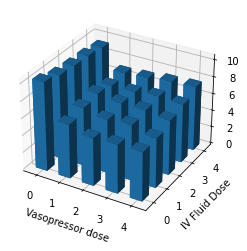

In [186]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
xpos, ypos = np.meshgrid(x_edges_old[:-1] + 0.25, y_edges_old[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5
dz = hist_old.ravel()
ax.set_ylabel('IV Fluid Dose')
ax.set_xlabel('Vasopressor dose')
#plt.xscale("log")
#plt.yscale("log")
#ax.set_zlabel('Signal Intensity')
ax.bar3d(ypos, xpos, zpos, dx, dy, dz)
plt.show()

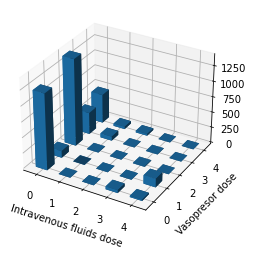

In [106]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
xpos, ypos = np.meshgrid(x_edges_cont[:-1] + 0.25, y_edges_cont[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5
dz = hist2_cont.ravel()
ax.set_ylabel('Vasopresor dose')
ax.set_xlabel('Intravenous fluids dose')
#ax.set_zlabel('Signal Intensity')
ax.bar3d(ypos, xpos, zpos, dx, dy, dz)
plt.show()

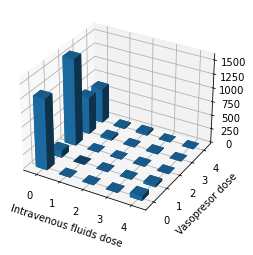

In [107]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
xpos, ypos = np.meshgrid(x_edges_cont_sec[:-1] + 0.25, y_edges_cont_sec[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5
dz = hist2_cont_sec.ravel()
ax.set_ylabel('Vasopresor dose')
ax.set_xlabel('Intravenous fluids dose')
#ax.set_zlabel('Signal Intensity')
ax.bar3d(ypos, xpos, zpos, dx, dy, dz)
plt.show()

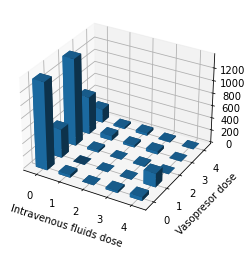

In [108]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
xpos, ypos = np.meshgrid(x_edges_old[:-1] + 0.25, y_edges_old[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5
dz = hist2_old.ravel()
ax.set_ylabel('Vasopresor dose')
ax.set_xlabel('Intravenous fluids dose')
#ax.set_zlabel('Signal Intensity')
ax.bar3d(ypos, xpos, zpos, dx, dy, dz)
plt.show()

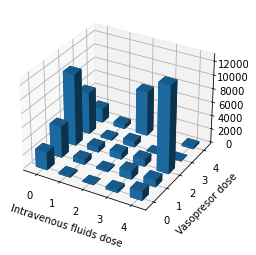

In [109]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
xpos, ypos = np.meshgrid(x_edges_test[:-1] + 0.25, y_edges_test[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5
dz = hist2_test.ravel()
ax.set_ylabel('Vasopresor dose')
ax.set_xlabel('Intravenous fluids dose')
#ax.set_zlabel('Signal Intensity')
ax.bar3d(ypos, xpos, zpos, dx, dy, dz)
plt.show()

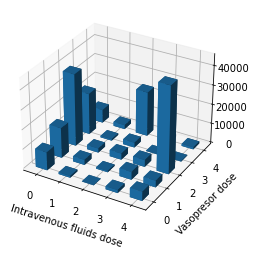

In [110]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
xpos, ypos = np.meshgrid(x_edges_train[:-1] + 0.25, y_edges_train[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5
dz = hist2_train.ravel()
ax.set_ylabel('Vasopresor dose')
ax.set_xlabel('Intravenous fluids dose')
#ax.set_zlabel('Signal Intensity')
ax.bar3d(ypos, xpos, zpos, dx, dy, dz)
plt.show()

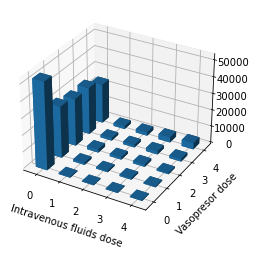

In [111]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
xpos, ypos = np.meshgrid(x_edges_train[:-1] + 0.25, y_edges_train[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5
dz = hist_train.ravel()
ax.set_ylabel('Vasopresor dose')
ax.set_xlabel('Intravenous fluids dose')
#ax.set_zlabel('Signal Intensity')
ax.bar3d(ypos, xpos, zpos, dx, dy, dz)
plt.show()